In [53]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, precision_score, \
recall_score, roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

Был выбран датасет со свойствами красных вин, а также их оценками. Вино считается хорошим, если ему поставили оценку > 6.5.
<BR><a href='https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009'>Ссылка на датасет</a>

В качестве таргета классификации возмём тот факт - хорошее вино или нет.
<BR>В качестве таргета регрессии - саму оценку вина

In [2]:
df = pd.read_csv('winequality-red.csv')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Давайте посмотрим на датасет

In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Видим, что ни в одной колонке нет значений NaN, а также нет ни одного категориального признака - значит, мы можем обойтись без предобработки данных

Введем колонку, которая будет индикатором того, что вино хорошее

In [8]:
df['is_good'] = (df['quality'] > 6.5).astype(int)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_good
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,0


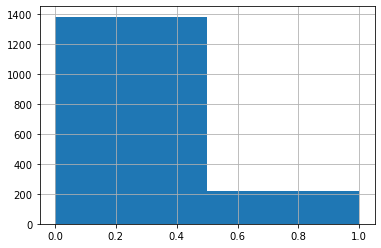

In [9]:
df.is_good.hist(bins=2)

Мы можем заметить, что хороших вин намного меньше, чем плохих. Следовательно, в качестве объективной оценки наших алгоритмов будем использовать f1 меру, но также посмотрим на такие величины, как accuracy, precision, recall.

Модели, которые будем использовать - логистическая регрессия, случайный лес и градиентный бустинг

Для того, чтобы подобрать наилучшие гиперпараметры для наших моделей - используем GridSearch с кроссвалидацией на трёх фолдах. Оценивать модели мудем по мере f1

In [46]:
scaler = StandardScaler()
X_train = df.drop(['quality', 'is_good'], axis=1).values
X_train = scaler.fit_transform(X_train)
y_train = df.is_good.values

In [47]:
f1_scorer = make_scorer(f1_score)
params = {
    'C': np.logspace(-3, 2, 6, base=10),
    'tol': np.logspace(0, 4, 5, base=0.1)
}
cv = KFold(3)

clf = GridSearchCV(LogisticRegression(), params, scoring=f1_scorer, cv=cv)
clf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'tol': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score), 

In [48]:
clf.best_score_, clf.best_estimator_
clf_lr = clf.best_estimator_

In [49]:
f1_scorer = make_scorer(f1_score)
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9, 11, 13],
    'min_samples_split': np.logspace(1, 4, 4, base=2, dtype=int),
}
cv = KFold(3)
clf = GridSearchCV(RandomForestClassifier(), params, scoring=f1_scorer, cv=cv, verbose=1)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:   31.0s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_s

In [50]:
clf.best_score_, clf.best_estimator_
clf_rf = clf.best_estimator_

In [51]:
params = {
    'max_depth': np.linspace(3, 7, 5, dtype=int),
    'learning_rate': np.logspace(1, 5, 5, base=0.6),
    'booster': ['gbtree', 'gblinear', 'dart'],
}
cv = KFold(3)
clf = GridSearchCV(XGBClassifier(), params, scoring=f1_scorer, cv=cv)
clf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=No...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid='deprecated', n_jobs=None,
             param_grid={'booster':

In [52]:
clf.best_score_, clf.best_estimator_
clf_xgb = clf.best_estimator_

Давайте сравним 3 наших классификатора. Возьмём лучшие модели и посчитаем для них значения f1, accuracy, precision, recall

In [54]:
x_tr, x_test, y_tr, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [55]:
clf_lr.fit(x_tr, y_tr)
clf_rf.fit(x_tr, y_tr)
clf_xgb.fit(x_tr, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.21599999999999997, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [61]:
for estimator in [clf_lr, clf_rf, clf_xgb]:
    y_pred = estimator.predict(x_test)
    f1 = f1_score(y_pred, y_test)
    acc = accuracy_score(y_pred, y_test)
    prec = precision_score(y_pred, y_test)
    rec = recall_score(y_pred, y_test)
    print("{}: \nf1 = {}, accuracy = {}, precision = {}, recall = {}\n".\
          format(estimator.__class__.__name__, f1, acc, prec, rec))

LogisticRegression: 
f1 = 0.4242424242424242, accuracy = 0.88125, precision = 0.35, recall = 0.5384615384615384

RandomForestClassifier: 
f1 = 0.5483870967741935, accuracy = 0.9125, precision = 0.425, recall = 0.7727272727272727

XGBClassifier: 
f1 = 0.4347826086956522, accuracy = 0.878125, precision = 0.375, recall = 0.5172413793103449



Мы видим, что лучше всех по всем метрикам оказался классификатор на базе случайного леса. Давайте взглянем на самые важные фичи

In [65]:
importances = clf_rf.feature_importances_
columns = df.drop(['quality', 'is_good'], axis=1).columns
for i in importances.argsort()[::-1]:
    print("{}: {}".format(columns[i], importances[i]))

alcohol: 0.19152877358993992
sulphates: 0.13612507380800015
volatile acidity: 0.10950686222412216
total sulfur dioxide: 0.09031354633333123
citric acid: 0.08915625171526104
density: 0.08422748003662829
fixed acidity: 0.06904768714085109
chlorides: 0.06404840407636982
free sulfur dioxide: 0.055735161945055324
pH: 0.05524167240642351
residual sugar: 0.05506908672401739


Интересно, самый важный признак - крепость напитка :)

Теперь перейдём к решению задачи регрессии. Набор фичей оставим тот же самый

In [67]:
y_train = df.quality.values

Модели, которые будем использовать - линейная регрессия, случайный лес и градиентный бустинг

Для линейной регрессии мы не сможем перебрать параметры, поэтому просто обучим её

In [71]:

cv = KFold(3)
scores = []
for train_ind, test_ind in cv.split(X_train):
    reg = LinearRegression()
    reg.fit(X_train[train_ind], y_train[train_ind])
    pred = reg.predict(X_train[test_ind])
    sc = mean_squared_error(pred, y_train[test_ind])
    scores.append(sc)
print(np.array(scores).mean())

0.4480087139655308


Опять же будем подбирать параметры с помощью GridSearch на трёх фолдах, но для задачи регрессии возьмём меру MSE

In [90]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
params = {
    'criterion': ['mse', 'mae'],
    'max_depth': [3, 5, 7],
    'min_samples_split': np.logspace(1, 4, 4, base=2, dtype=int),
}
cv = KFold(3)
reg = GridSearchCV(RandomForestRegressor(), params, scoring=mse_scorer, cv=cv, verbose=1)
reg.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.5min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             ve

In [91]:
reg_rf = reg.best_estimator_
reg.best_score_, reg.best_estimator_

(-0.42548323165648344,
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False))

In [92]:
params = {
    'max_depth': np.linspace(3, 7, 5, dtype=int),
    'learning_rate': np.logspace(1, 5, 5, base=0.6),
    'booster': ['gbtree', 'gblinear', 'dart'],
}
cv = KFold(3)
reg = GridSearchCV(XGBRegressor(), params, scoring=mse_scorer, cv=cv)
reg.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=Non...
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'learning_rate': array([0.6    , 0.36   , 0.216  , 0.1296 , 0.077

In [93]:
reg_xgb = reg.best_estimator_
reg.best_score_, reg.best_estimator_

(-0.43212917767651654,
 XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.07775999999999998, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None))

In [94]:
reg_lr = LinearRegression()

In [95]:
x_tr, x_test, y_tr, y_test = train_test_split(X_train, y_train, test_size=0.2)

Давайте сравним наши модели. За метрику качества возьмём 3 значения MSE, RMSE, MAPE

In [98]:
def RMSE(y1, y2):
    return mean_squared_error(y1, y2) ** 0.5

def MAPE(y1, y2):
    return (np.abs(y1 - y2) / y2).sum() / y1.shape[0]

for estimator in [reg_lr, reg_rf, reg_xgb]:
    estimator.fit(x_tr, y_tr)
    y_pred = estimator.predict(x_test)
    mse = mean_squared_error(y_pred, y_test)
    rmse = RMSE(y_pred, y_test)
    mape = MAPE(y_pred, y_test)
    print("{}: \nMSE = {}, RMSE = {}, MAPE = {}\n".\
          format(estimator.__class__.__name__, mse, rmse, mape))

LinearRegression: 
MSE = 0.4054871190519397, RMSE = 0.6367787049296951, MAPE = 0.09145198367183023

RandomForestRegressor: 
MSE = 0.3654774671541763, RMSE = 0.6045473241642678, MAPE = 0.08466570889117754

XGBRegressor: 
MSE = 0.3764713208524249, RMSE = 0.613572588087526, MAPE = 0.0884679944795512



Самая лучший результат (самые маленькие ошибки) опять показал random forest. Давайте снова посмотрим на самые важные фичи. Средняя абсолютная ошибка равна 8.5%

In [100]:
importances = reg_rf.feature_importances_
columns = df.drop(['quality', 'is_good'], axis=1).columns
for i in importances.argsort()[::-1]:
    print("{}: {}".format(columns[i], importances[i]))

alcohol: 0.3262160942128026
sulphates: 0.18704264786549726
volatile acidity: 0.14511010277778508
total sulfur dioxide: 0.07279764041365938
pH: 0.044632731947859626
chlorides: 0.04413149082877702
residual sugar: 0.03999337028200691
fixed acidity: 0.038413362843427355
density: 0.036094024262252916
free sulfur dioxide: 0.03299152339376774
citric acid: 0.032577011172164015


Опять же самый важный признак - крепость напитка.